# Lets predict the Bike Rentals per hour in Washington D.C.
![bikes](bikes.jpg)

## Introduction
Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.
    
[Hadi Fanaee-T](http://www.fanaee.com/) at the University of Porto compiled this data into a CSV file. 

## Resources
The file can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).


### Data Dictionary
Here are the details about the relevant columns 

|Feature|Description|
|:-------|:-------|
|instant | A unique sequential ID number for each row|
|dteday | The date of the rentals|
|season | The season in which the rentals occurred|
|yr | The year the rentals occurred|
|mnth | The month the rentals occurred|
|hr | The hour the rentals occurred|
|weekday | The day of the week (as a number, 0 to 7)|
|holiday | Whether or not the day was a holiday|
|workingday | Whether or not the day was a working day|
|weathersit | The weather (as a categorical variable)|
|atemp | The adjusted 'feeling' temperature|
|temp | The temperature|
|hum | The humidity|
|windspeed | The wind speed|
|casual | The number of casual riders (people who hadn't previously signed up with the bike sharing program)|
|registered | The number of registered riders (people who had already signed up)|
|cnt | The total number of bike rentals (casual + registered)|



## Goal:
Predicting the total number of bikes people rented in a given hour. Predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, create a few different machine learning models and evaluate their performance.

---

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error


In [2]:
# Display Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

In [3]:
# Load Dataset
bike = pd.read_csv('bike_rental_hour.csv', index_col=0) # col 'instant' as index

---

### Data Exploration

In [4]:
bike.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


- No null values found.
- Column `dteday`, representing dates is in object Dtype

In [6]:
for col in bike.columns:
    print(col, bike[col].nunique())

dteday 731
season 4
yr 2
mnth 12
hr 24
holiday 2
weekday 7
workingday 2
weathersit 4
temp 50
atemp 65
hum 89
windspeed 30
casual 322
registered 776
cnt 869


- Columns `yr`, `holiday` and `workingday` each have 2 unique values 

In [7]:
for col in ['yr', 'holiday', 'workingday']:
    print(bike[col].value_counts())

1    8734
0    8645
Name: yr, dtype: int64
0    16879
1      500
Name: holiday, dtype: int64
1    11865
0     5514
Name: workingday, dtype: int64


- In column `yr`, over 97% of the values are 0 and less than 3% are 1. So the column has a very low variance 

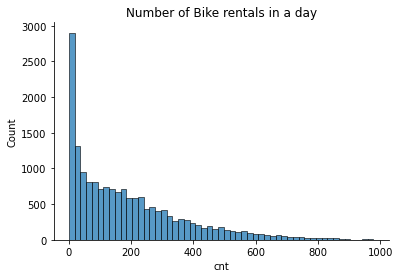

In [8]:
sns.histplot(bike['cnt'])
plt.title('Number of Bike rentals in a day')
sns.despine()

- The distribution is skewed to the right, meaning that lower number of values have higher frequencies. As it can be seen, for most of the times, **0** number of bikes were rented

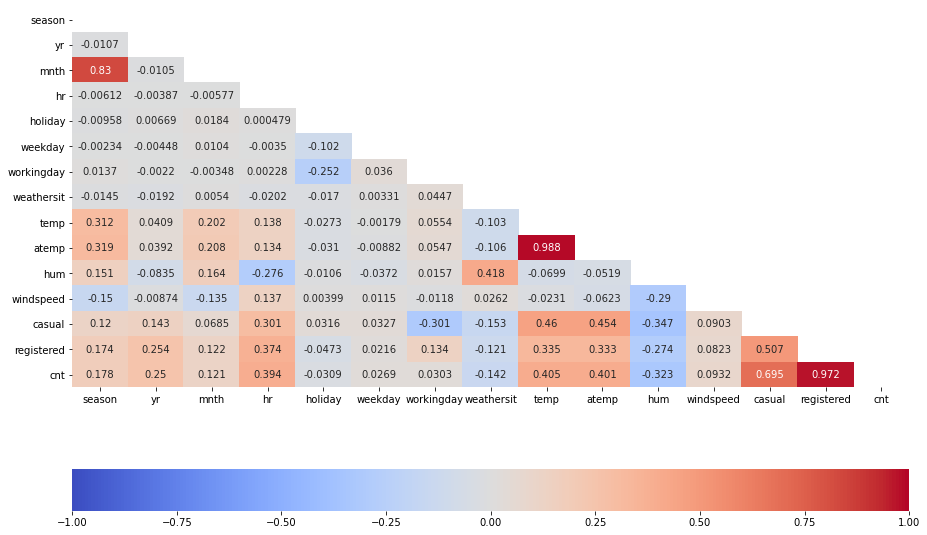

In [9]:
# Lets Plot a Correlation Matrix
plt.figure(figsize=(15,10))
bike_corr = bike.corr()

# To truncate for better view
mask = np.triu(np.ones_like(bike_corr, dtype=bool))

sns.heatmap(bike_corr, annot=True, fmt='.3g', vmin=-1, vmax=1, mask=mask, 
            center= 0, cmap= 'coolwarm',cbar_kws= {'orientation': 'horizontal'})

In the cell below, the correlation of `cnt` are shown as **absolute values** sorted in descending order.

In [10]:
bike.corr()['cnt'].abs().sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

- It is important to note that `registered` and `casual` sums up to our target value `cnt`. We can't include them to our models.

- Excluding the `registered` and `casual` columns, `temp`, `atemp`, `hr`, and `hum` have a considerable correlation with the target. `cnt`
    - `atemp` and `temp` collinear
    
---

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.
### Managing Features

`hr` column stands for the **hour** during which bikes are rented, from 1 to 24.

A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

In [11]:
def assign_label(hour):
    '''The function returns the time bundled in
    either morning, afternoon, evening or night.
    The numbers 1, 2, 3, and 4 corresponds to the 
    time categories'''
    if hour >=0 and hour < 6:
        return 1
    elif hour >=6 and hour < 12:
        return 2
    elif hour >= 12 and hour < 18:
        return 3
    elif hour >= 18 and hour <=24:
        return 4


In [12]:
# Lets assign the values back to the DataFrame
bike['time_label'] = bike['hr'].apply(assign_label)

# A brief look into the frequencies
bike['time_label'].value_counts()

3    4375
4    4368
2    4360
1    4276
Name: time_label, dtype: int64

---

## Application of Machine Learning Algorithms

We will use **Mean Squared Error, MSE** as our error metric as our target `cnt` is a continuous variable. MSE is sensitive to outliers, punishes larger error more than MAE (which treats larger and smaller errors equally) and R2. MAE and R2 are insensitive to Outliers

#### Splitting the dataset into train and test 
Lets split the dataset using `sample method`

In [13]:
# Randomly allocate 80% of the rows to train
train = bike.sample(frac=.8)

# Allocate all the remaining rows to test
test = bike.loc[~bike.index.isin(train.index)]

#### Feature Selection
We will remove remove following columns 
- `dteday`: The information in this column is not meaningful for our purpose
- `casual` and `registered`: These columns combine to make our target variable. So they will cause data leakage
- `temp`: It is collinear with `atemp`. We chose the latter one as intuitively, 'feels-like' temperature sounds more impactful
- `yr`: This feature is dominated by one category. Thus it doesn't provide with significant variance

And finally, we will also remove the target variable `cnt` as well

In [14]:
features = list(train.columns)

In [15]:
features.remove('cnt')
features.remove('casual')
features.remove('registered')
features.remove('dteday')
features.remove('temp')
features.remove('yr')

In [16]:
features

['season',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

Lets begin with applying models 

---

### Linear Regression

In [17]:
# Instantiate
lr = LinearRegression()

# Fit
lr.fit(train[features], train['cnt'])

# Predict on train
pred_train = lr.predict(train[features])

# Predict on test
pred_test = lr.predict(test[features])

# Error (arg squared=True returns MSE, False returns RMSE)
lr_mse_train = mean_squared_error(train['cnt'], pred_train, squared=True)
lr_mse_test = mean_squared_error(test['cnt'], pred_test, squared=True)
print('MSE on train:',lr_mse_train)
print('MSE on test:',lr_mse_test)


MSE on train: 21018.524975544846
MSE on test: 21455.31902326155


**Observations:**
- The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.
- Otherwise, it could not be said that the model is Overfitting because the difference between the test MSE and train MSE is very low

**What we can do?**
- Remove the outliers from the data
    - A possible way to get rid of outliers is to oust the samples that are beyond the product of an arbitrary threshold and IQR. 

- Optimize the model using Hyperparameter optimization
    - Using GridSearch to find optimum parameters
- Remove the features with no impactful correlation
    - Less useful features could be the ones with little or no correlation and the ones that do not provide variability to the data
    
Lets use **GridSearchCV** for now. We will return to implement the rest of the mentioned ideas if GridSearchCV or other models do not give us better results. As we will often have to work with GridSearchCV, lets make a function on it

- There is very insignificant improvement. Lets move on to other models 

In [30]:
params = {'copy_X': [True, False], 
          'fit_intercept': [True, False], 
          'normalize': [True,False]}

def apply_grid (df, model, features, target, params, test=False):
    '''
    Performs GridSearchCV after re-splitting the dataset, provides
    comparsion between train's MSE and test's MSE to check for 
    Generalization and optionally, deploys the best found parameters 
    on the Test Set as well.
    
    Args:
        df: DataFrame
        model: model to use
        features: features to consider
        target: labels
        params: Param_Grid for Optimization
        test: False by Default, if True, predicts on Test
        
    Returns:
        MSE scores on models and slice from the cv_results_
        to compare the models generalization performance
    '''
    
    my_model = model()
    # Split the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                        df['cnt'], random_state=0)
    
    # Resplit the train dataset for GridSearchCV into train2 and valid to keep the test set separate
    X_train2, X_valid, y_train2, y_valid = train_test_split(train[features],
                                                          train['cnt'] , random_state=0)
    
    # Use Grid Search to find the best parameters from the param_grid
    grid = GridSearchCV(estimator=my_model, param_grid=params, cv=3,
                        return_train_score=True, scoring='neg_mean_squared_error')
    grid.fit(X_train2, y_train2)
    
    # Evaluate on Valid set
    scores = grid.score(X_valid, y_valid)
    scores = scores 
    print('Best MSE through GridSearchCV on X_valid and y_valid: ', scores*(-1))
    print('Best Parameters found through GridSearchCV: ', grid.best_params_)
    print('The mean MSE of the best estimator from GridSearchCV: ', grid.best_score_*(-1))
    print('-'*120)
    print('mean_test_score in following slice is rather mean_valid_score')
    report = pd.DataFrame(grid.cv_results_)
    
    # If test is True, deploy the best_params_ on the test set
    if test == True:
        my_model = model(**grid.best_params_)
        my_model.fit(X_train, y_train)

        predictions = my_model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        print('MSE with best parameters on Test Set: ', mse)
        print('-'*120)
    
    return report[['mean_train_score', 'mean_test_score']]*(-1)   

In [31]:
apply_grid(bike, LinearRegression, features, 'cnt', params, test=True)

Best MSE through GridSearchCV on X_valid and y_valid:  20725.545599409135
Best Parameters found through GridSearchCV:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
The mean MSE of the best estimator from GridSearchCV:  21208.151039523294
------------------------------------------------------------------------------------------------------------------------
mean_test_score in following slice is rather mean_valid_score
MSE with best parameters on Test Set:  21265.191156321875
------------------------------------------------------------------------------------------------------------------------


,mean_train_score,mean_test_score
0,21104.485496,21208.151040
1,21104.485496,21208.151040
2,21138.508702,21238.874354
3,21138.508702,21238.874354
4,21104.485496,21208.151040
5,21104.485496,21208.151040
6,21138.508702,21238.874354
7,21138.508702,21238.874354


- It can be clearly seen that the Linear Regression model with the best of the given parameters is definitely not **Overfitting** but rather it is **Underfitting**

Lets move on to other models 

### DecisionTree Regression

Lets Apply DecisionTree Regressor on Test to see the results on Test

In [20]:
# Instantiate
tree = DecisionTreeRegressor()

# Fit
tree.fit(train[features], train['cnt'])

# Predict
pred_train = tree.predict(train[features])
pred_test = tree.predict(test[features])

# Error
mse_train = mean_squared_error(train['cnt'], pred_train, squared=True)
mse_test = mean_squared_error(test['cnt'], pred_test, squared=True)
print('MSE on train:',mse_train)
print('MSE on test:',mse_test)


MSE on train: 3.3698841976551823
MSE on test: 8219.56336306099


- A Decision Tree with default setting of parameters has been much more accurate than the Linear Regression model, however, the discrepancy between MSE on train and MSE on test shows that the model is **overfitting** very badly

Lets try readjusting a single parameter called `min_samples_leaf` to see the direction of change

In [37]:
# Instantiate
tree = DecisionTreeRegressor(min_samples_leaf=2)

# Fit
tree.fit(train[features], train['cnt'])

# Predict
pred_test = tree.predict(test[features])
pred_train = tree.predict(train[features])

# Error
mse_test = mean_squared_error(test['cnt'], pred_test, squared=True)
mse_train = mean_squared_error(train['cnt'], pred_train, squared=True)

print('MSE on test:',mse_test)
print('MSE on train:',mse_train)


MSE on test: 7377.837263057793
MSE on train: 876.5248567455465


- There is a change. Decrease in the difference between MSE on train and MSE on test is a step towards Generalization

In [38]:
tree = DecisionTreeRegressor(min_samples_leaf=5)

X_train, X_test, y_train, y_test = train_test_split(train[features], train['cnt'], test_size=0.2)
tree.fit(X_train, y_train)

pred_test = tree.predict(X_test)
mse_test = mean_squared_error(y_test, pred_test, squared=True)
print('MSE on test: ', mse_test)

pred_train = tree.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train, squared=True)
print('MSE on train: ', mse_train)

MSE on test:  6624.0303564613905
MSE on train:  2578.17910615454


- Increament in `min_samples_leaf` seems coming better

In [144]:
dict_tree_mse_min_samples_leaf = {}
for i in np.arange(1,50,1):
    tree = DecisionTreeRegressor(min_samples_leaf=i)

    X_train, X_test, y_train, y_test = train_test_split(train[features], train['cnt'], test_size=0.2)
    tree.fit(X_train, y_train)

    pred_test = tree.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    #print('MSE on test: ', mse_test)

    pred_train = tree.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    #print('MSE on train: ', mse_train)
    dict_tree_mse_min_samples_leaf[i] = [mse_test, mse_train]
    
    

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


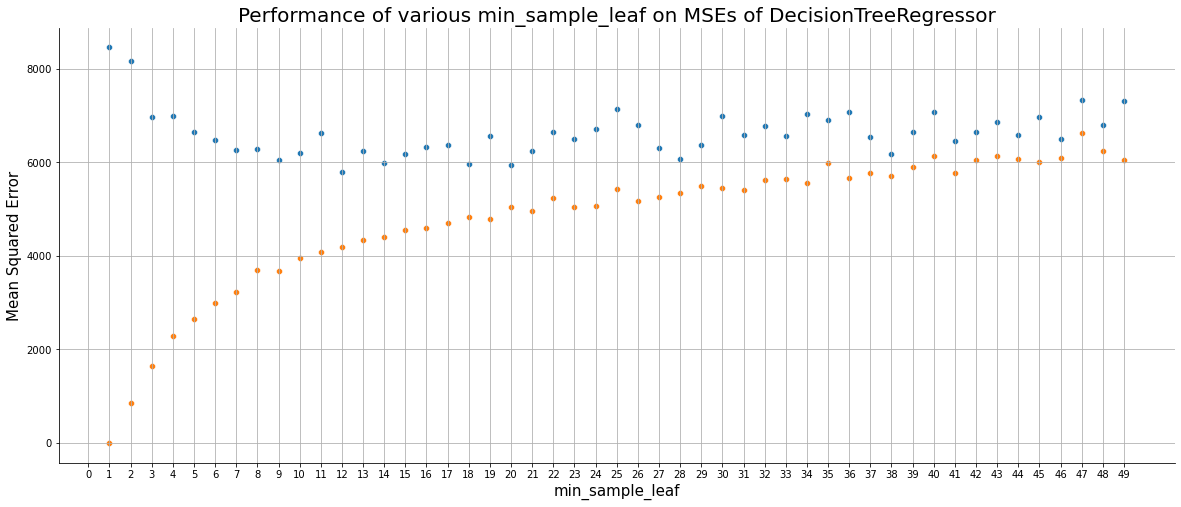

In [162]:
tree_min_sample_leaf = []
tree_train_mse = []
tree_test_mse = []


for i, v in dict_tree_mse_min_samples_leaf.items():
    tree_min_sample_leaf.append(i)
    tree_train_mse.append(v[0])
    tree_test_mse.append(v[1])
plt.figure(figsize=(20,8))    
sns.scatterplot(tree_min_sample_leaf, tree_train_mse)
sns.scatterplot(tree_min_sample_leaf, tree_test_mse)
plt.xticks(np.arange(0,50))
sns.despine()

plt.xlabel('min_sample_leaf', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.title('Performance of various min_sample_leaf on MSEs of DecisionTreeRegressor', fontsize=20)

plt.grid()
plt.show()

- Its clear that for lower values of `min_sample_split`, the model Overfits quite badly
- As the `min_sample_split` increases, we get better on Generalization but at the cost of increasing test MSE
- A trade-off pair of values could be considered at `min_sample_split` = 24 or 28
- In terms of the least difference between training MSE and testing MSE, `min_sample_split` = 45 seems obvious

To dig it deeper, lets apply our function apply_grid

In [125]:
params = {'max_depth': np.arange(9,15), 
          'max_leaf_nodes': np.arange(100,200,1), 
          'min_samples_leaf': np.arange(20, 23, 1),
          'min_samples_split': [2,3]}
apply_grid(bike, DecisionTreeRegressor, features, 'cnt', params)

Best MSE through GridSearchCV on X_valid and y_valid:  6319.263362583472
Best Parameters found through GridSearchCV:  {'max_depth': 13, 'max_leaf_nodes': 199, 'min_samples_leaf': 20, 'min_samples_split': 2}
The mean MSE of the best estimator from GridSearchCV:  6950.708636412924
------------------------------------------------------------------------------------------------------------------------
mean_test_score in following slice is rather mean_valid_score
MSE with best parameters on Test Set:  6400.769335327489
------------------------------------------------------------------------------------------------------------------------


,mean_train_score,mean_test_score
0,6625.551208,7639.491404
1,6625.551208,7639.491404
2,6645.521741,7670.129036
3,6645.521741,7670.129036
4,6660.612536,7659.303159
...,...,...
3595,5439.154198,6954.937175
3596,5522.335614,7004.891913
3597,5522.335614,7004.891913
3598,5628.212666,7077.373955


- After lots of iterations with different combinations of params, another significant parameter was found to be `max_leaf_nodes`

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


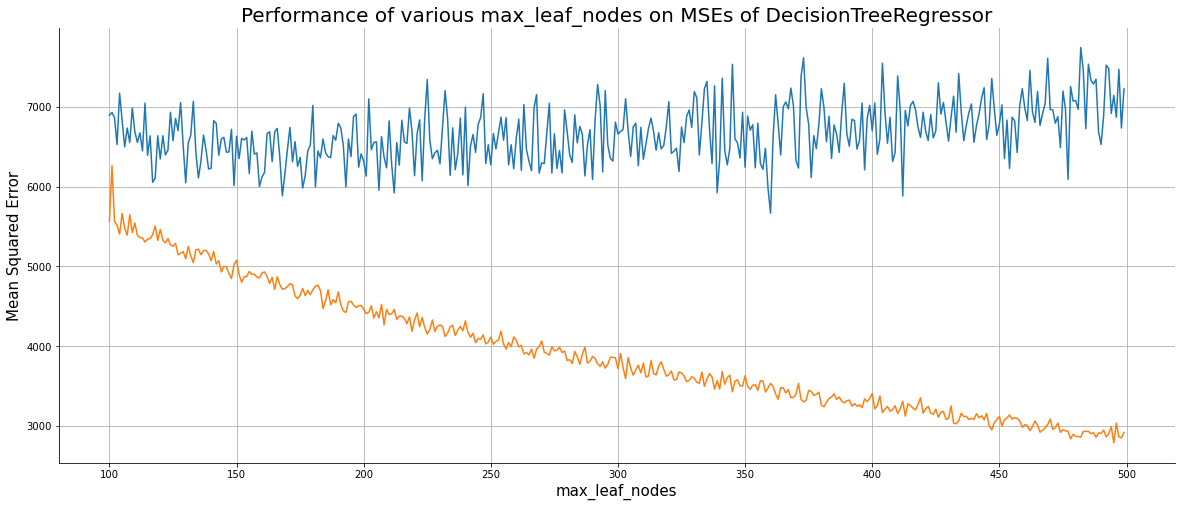

In [163]:
dict_tree_mse_max_leaf_nodes = {}
for i in np.arange(100,500,1):
    tree = DecisionTreeRegressor(max_leaf_nodes=i)

    X_train, X_test, y_train, y_test = train_test_split(train[features], train['cnt'], test_size=0.2)
    tree.fit(X_train, y_train)

    pred_test = tree.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)

    pred_train = tree.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)

    dict_tree_mse_max_leaf_nodes[i] = [mse_test, mse_train]
    
tree_max_leaf_nodes = []
tree_train_mse = []
tree_test_mse = []


for i, v in dict_tree_mse_max_leaf_nodes.items():
    tree_max_leaf_nodes.append(i)
    tree_train_mse.append(v[0])
    tree_test_mse.append(v[1])
plt.figure(figsize=(20,8))    
sns.lineplot(tree_max_leaf_nodes, tree_train_mse)
sns.lineplot(tree_max_leaf_nodes, tree_test_mse)

plt.xlabel('max_leaf_nodes', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.title('Performance of various max_leaf_nodes on MSEs of DecisionTreeRegressor', fontsize=20)

sns.despine()
plt.grid()
plt.show()  

- Since the graph is showing only the `max_leaf_nodes` effect, without considering other parameters into the play, we can not assume the same results alongwith other parameters. Other parameters' influence might change this relationship, **something I witnessed as well while doing trial-and-error with other parameters alongsides `max_leaf_nodes`**

In [137]:
params = {'max_depth': np.arange(9,15), 
          'max_leaf_nodes': np.arange(100,200,1), 
          'min_samples_leaf': np.arange(20, 23, 1),
          'min_samples_split': [2,3]}
apply_grid(bike, DecisionTreeRegressor, features, 'cnt', params, test=True)

Best MSE through GridSearchCV on X_valid and y_valid:  6316.673532833844
Best Parameters found through GridSearchCV:  {'max_depth': 13, 'max_leaf_nodes': 199, 'min_samples_leaf': 20, 'min_samples_split': 2}
The mean MSE of the best estimator from GridSearchCV:  6950.708636412924
------------------------------------------------------------------------------------------------------------------------
mean_test_score in following slice is rather mean_valid_score
MSE with best parameters on Test Set:  6400.769335327489
------------------------------------------------------------------------------------------------------------------------


,mean_train_score,mean_test_score
0,6625.551208,7639.491404
1,6625.551208,7639.491404
2,6645.521741,7670.129036
3,6645.521741,7670.129036
4,6660.612536,7659.303159
...,...,...
3595,5439.154198,6954.937175
3596,5522.335614,7004.891913
3597,5522.335614,7004.891913
3598,5628.212666,7077.373955


Lets move on to RandomForestRegressor 

### Random Forest Regression

In [138]:
# Instantiate
rf = RandomForestRegressor()

# Fit
rf.fit(train[features], train['cnt'])

# Predict
pred_train = rf.predict(train[features])
pred_test = rf.predict(test[features])

# Error
mse_train = mean_squared_error(train['cnt'], pred_train)
mse_test = mean_squared_error(test['cnt'], pred_test)
print('MSE on train:',mse_train)
print('MSE on test:',mse_test)


MSE on train: 636.7874928101256
MSE on test: 4555.13611970493


A default Random Forest model has better results than a default Decision Tree model

#### Lets experiment with RandomForest Regressor by readjusting its parameter

In [155]:
min_sample_leaves = range(1,50)
rf_mse_dict = {}
for num in min_sample_leaves:
    # Instantiate
    rf = RandomForestRegressor(min_samples_leaf = num)

    # Fit
    rf.fit(train[features], train['cnt'])

    # Predict
    pred_train = rf.predict(train[features])
    pred_test = rf.predict(test[features])

    # Error
    mse_train = mean_squared_error(train['cnt'], pred_train)
    mse_test = mean_squared_error(test['cnt'], pred_test)
    rf_mse_dict[num] = mse_train, mse_test

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


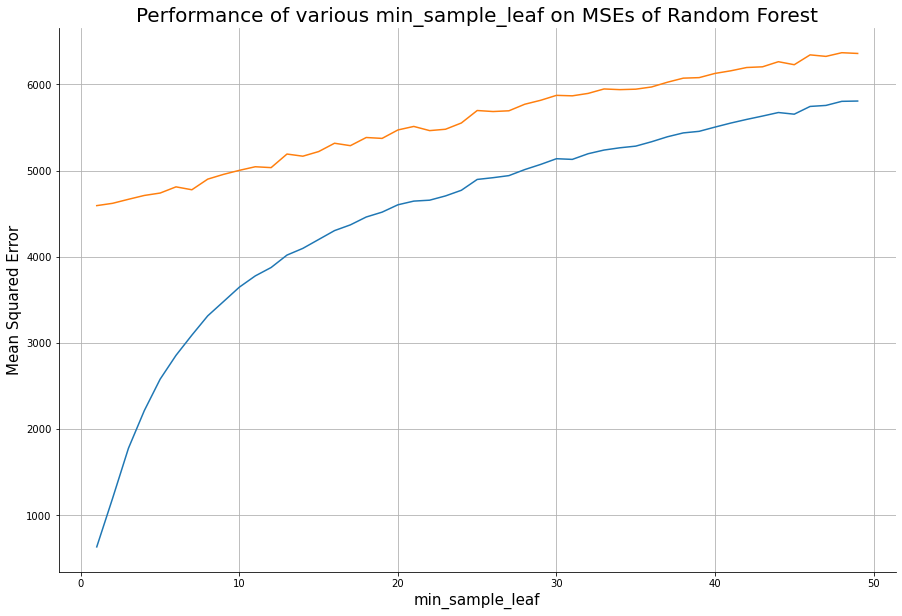

In [164]:
rf_mses = pd.DataFrame(rf_mse_dict).T
rf_mses = rf_mses.rename(columns={0:'MSE train', 1:'MSE test'})
plt.figure(figsize=(15,10))
sns.lineplot(rf_mses.index, rf_mses['MSE train'])
sns.lineplot(rf_mses.index, rf_mses['MSE test'])

plt.xlabel('min_sample_leaf', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.title('Performance of various min_sample_leaf on MSEs of Random Forest', fontsize=20)

sns.despine()
plt.grid()
plt.show()  

- An increase in `min_sample_leaf` helps containing the Overfitting but, it increases the MSE as well

In [165]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 49,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Random Forests Model performed better that Decision Trees to bring the Mean Squared Error down. 
Lets work further to enhance its performance

# TBC